## MARBL diagnostics for vertical and horizontal nutrient distribution for ocean history files

## This notebook compares 3 tuning runs

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats

### Define the years over which to average, the case and experiment name

In [2]:
start_yr = 3 #start at year 3 and get 2 years over which to average
num_years = 1
endyr = start_yr + num_years 
casename = 'g.e22a06.G1850ECOIAF.T62_g37.4p4z.'
exp = 'test_z4_mort2'
user = 'kristenk'

### Define variables that would be interesting

In [3]:
variables = ['photoC_TOT_zint','photoC_sp_zint',
             'photoC_diat_zint','photoC_diaz_zint','photoC_cocco_zint','POC_FLUX_100m',
             'diatC', 'coccoC','spC','diazC',
             'PO4','Fe','NO3','SiO3',
             'spChl','diatChl','diazChl','coccoChl',
            'zoo1C','zoo2C','zoo3C','zoo4C','x_graze_zoo1_zint','x_graze_zoo2_zint',
            'x_graze_zoo3_zint','x_graze_zoo4_zint'] 
coords = {'x':'TLONG','y':'TLAT'}

keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']

In [4]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2018_x3POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)

In [5]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
depths=ds_woa.z_t * 0.01

## zoo4's z_mort2_0_per_day

In [6]:
#define test cases
varname='z4_mort2'
casenums=[varname+'_1', varname+'_2', varname+'_3']
test_vals=[0.01, 0.008, 0.003]

#### open each dataset and put them in a dictionary organized by casenum

In [7]:
ds_dict = {}
for casenum in casenums:
    case=casename + exp + '.' + casenum
    print(case)
    files = []
    for year in range(start_yr,endyr):
        
        yr4 = "{:04d}".format(year)
        print('doing simulation year', year, '!')
        for month in range(1, 13):

            mo2 = "{:02d}".format(month)
            files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc')))
            
            ds = xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')
            ds = ds.drop([v for v in ds.variables if v not in keep_vars])
            ds = ds.mean(dim='time')
            
            ds_dict[casenum] = ds

g.e22a06.G1850ECOIAF.T62_g37.4p4z.test_z4_mort2.z4_mort2_1
doing simulation year 3 !
g.e22a06.G1850ECOIAF.T62_g37.4p4z.test_z4_mort2.z4_mort2_2
doing simulation year 3 !
g.e22a06.G1850ECOIAF.T62_g37.4p4z.test_z4_mort2.z4_mort2_3
doing simulation year 3 !


### Evaluation of global nutrient distributions

In [8]:
rmse_dict={}

for casenum in casenums:
    
    ds_dict[casenum]['z_t']=ds_woa.z_t

    rmse_global = xr.Dataset({v: ds_dict[casenum][v] for v in ['z_t']})
    #help(esmlab.statistics)
    rmse_global['NO3']=esmlab.statistics.weighted_rmsd(ds_dict[casenum].NO3, ds_woa.NO3, dim=['nlat', 'nlon'], weights=area)
    rmse_global['PO4']=esmlab.statistics.weighted_rmsd(ds_dict[casenum].PO4, ds_woa.PO4, dim=['nlat', 'nlon'], weights=area)
    rmse_global['SiO3']=esmlab.statistics.weighted_rmsd(ds_dict[casenum].SiO3, ds_woa.SiO3, dim=['nlat', 'nlon'], weights=area)
    
    rmse_dict[casenum]=rmse_global

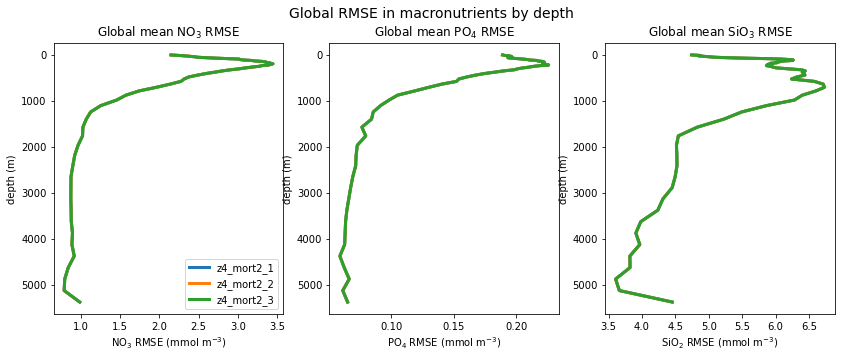

In [9]:
fig = plt.figure(figsize=(14,5))

plt.suptitle('Global RMSE in macronutrients by depth', fontsize=14)
#################
ax = fig.add_subplot(1,3,1)
ax.set_title('Global mean NO$_3$ RMSE')
for casenum in casenums:
    ax.plot(rmse_dict[casenum]['NO3'].values, depths, label=casenum, linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ RMSE (mmol m$^{-3}$)')
plt.gca().invert_yaxis()
#################
ax = fig.add_subplot(1,3,2)
ax.set_title('Global mean PO$_4$ RMSE')
for casenum in casenums:
    ax.plot(rmse_dict[casenum]['PO4'].values, depths, label=casenum, linewidth=3)
ax.set(ylabel='depth (m)',xlabel='PO$_4$ RMSE (mmol m$^{-3}$)')
plt.gca().invert_yaxis()
#################
ax = fig.add_subplot(1,3,3)
ax.set_title('Global mean SiO$_3$ RMSE')
for casenum in casenums:
    ax.plot(rmse_dict[casenum]['SiO3'].values, depths, label=casenum, linewidth=3)
ax.set(ylabel='depth (m)',xlabel='SiO$_2$ RMSE (mmol m$^{-3}$)')
plt.gca().invert_yaxis()
#################

### Globally integrated production

In [11]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'cocco', 'TOT']]

variables = variables + [f'x_graze_{zoo}_zint' for zoo in ['zoo1', 'zoo2', 'zoo3','zoo4']]

dict_glb = {}
for casenum in casenums:
    
    ds_glb = xr.Dataset()
    for v in variables:
        ds_glb[v] = esmlab.statistics.weighted_sum(ds_dict[casenum][v], weights=area, dim=['nlat', 'nlon'])
        ds_glb[v].attrs = ds_dict[casenum][v].attrs

        #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
        ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
        ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

    ds_glb = ds_glb.compute()
    
    ds_glb['TOTzoo']= ds_glb['x_graze_zoo1_zint'] + ds_glb['x_graze_zoo2_zint'] + ds_glb['x_graze_zoo3_zint'] + ds_glb['x_graze_zoo4_zint']
    
    dict_glb[casenum]=ds_glb

Text(0.5, 0, 'zoo4 z_mort2_0_per_day')

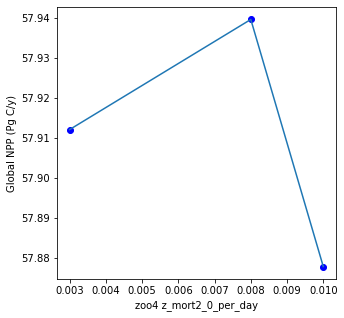

In [12]:
y_vals = np.empty([3])
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].photoC_TOT_zint.values
    i=i+1
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.scatter(test_vals,y_vals,color='blue',marker='o')
ax.plot(test_vals,y_vals)
ax.set_ylabel('Global NPP (Pg C/y)')
ax.set_xlabel('zoo4 z_mort2_0_per_day')
#ax.set_ylim(50,60)

Text(0.5, 0, 'zoo4 z_mort2_0_per_day')

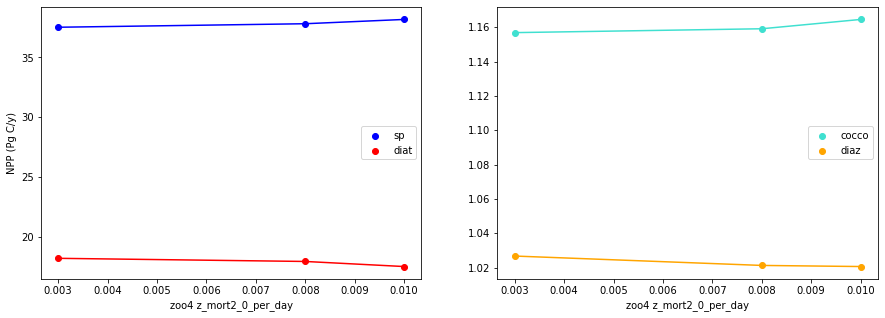

In [13]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,2,1)
y_vals = np.empty([3])
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].photoC_sp_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='blue',marker='o',label='sp')
ax.plot(test_vals,y_vals,color='blue')
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].photoC_diat_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='red',marker='o',label='diat')
ax.plot(test_vals,y_vals,color='red')
ax.legend()
ax.set_ylabel('NPP (Pg C/y)')
ax.set_xlabel('zoo4 z_mort2_0_per_day')

ax = fig.add_subplot(1,2,2)
y_vals = np.empty([3])
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].photoC_cocco_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='turquoise',marker='o',label='cocco')
ax.plot(test_vals,y_vals,color='turquoise')
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].photoC_diaz_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='orange',marker='o',label='diaz')
ax.plot(test_vals,y_vals,color='orange')
ax.legend()
ax.set_xlabel('zoo4 z_mort2_0_per_day')

Text(0.5, 0, 'zoo4 z_mort2_0_per_day')

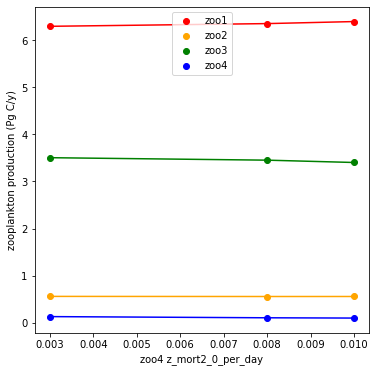

In [14]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(1,1,1)
y_vals = np.empty([3])
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].x_graze_zoo1_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='red',marker='o',label='zoo1')
ax.plot(test_vals,y_vals,color='red')
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].x_graze_zoo2_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='orange',marker='o',label='zoo2')
ax.plot(test_vals,y_vals,color='orange')
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].x_graze_zoo3_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='green',marker='o',label='zoo3')
ax.plot(test_vals,y_vals,color='green')
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].x_graze_zoo4_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='blue',marker='o',label='zoo4')
ax.plot(test_vals,y_vals,color='blue')

ax.legend()
ax.set_ylabel('zooplankton production (Pg C/y)')
ax.set_xlabel('zoo4 z_mort2_0_per_day')


In [15]:
goals_dict={}

for casenum in casenums:
    goals=xr.Dataset()
    goals['NPP'] = 55
    goals['diatNPP'] = 0.4 * dict_glb[casenum].photoC_TOT_zint.values
    goals['zooPROD'] = 0.25 * dict_glb[casenum].photoC_TOT_zint.values
    #goals['microzooPROD'] = 0.6 * dict_glb[casenum].x_graze_zoo1_zint.values + dict_glb[casenum].x_graze_zoo2_zint.values #(so uncertain!!)
    
    goals_dict[casenum]=goals
    

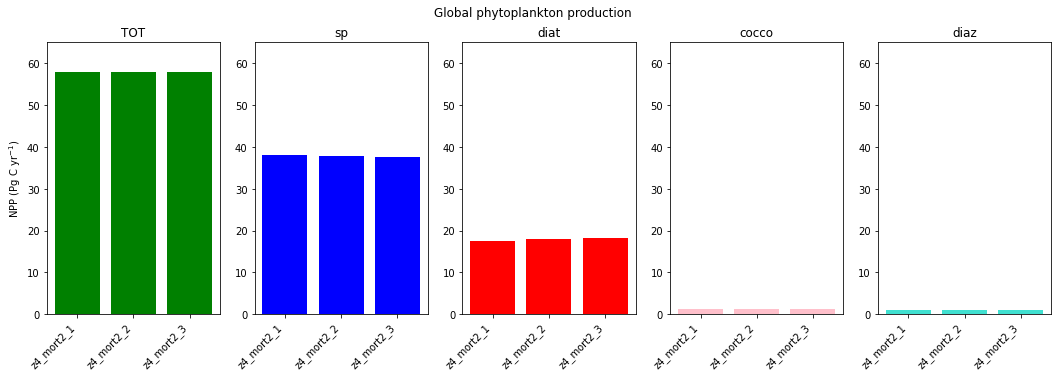

In [16]:
fig = plt.figure(figsize=(18,5))

plt.suptitle('Global phytoplankton production')

####### TOT
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+[casenum]
    vals[i]=dict_glb[casenum].photoC_TOT_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,1)
ax.bar(labels, vals,color='green')
# ax.plot([0,1,2],[goals_dict[casenum].NPP.values,goals_dict[casenum].NPP.values,goals_dict[casenum].NPP.values], color='black', marker='*')

ax.set_ylim(0,65)
ax.set_ylabel('NPP (Pg C yr$^{-1}$)')
ax.set_title('TOT')
plt.xticks(rotation=45, ha='right')

####### sp
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+[casenum]
    vals[i]=dict_glb[casenum].photoC_sp_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,2)
ax.bar(labels, vals,color='blue')
ax.set_ylim(0,65)
ax.set_title('sp')
plt.xticks(rotation=45, ha='right')

####### diat
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+[casenum]
    vals[i]=dict_glb[casenum].photoC_diat_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,3)
#ax.axhline(goals_dict[casenum].diatNPP.values, color='black', linestyle='--', lw=2)

ax.bar(labels, vals,color='red')
ax.set_ylim(0,65)
ax.set_title('diat')
plt.xticks(rotation=45, ha='right')

####### cocco
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+[casenum]
    vals[i]=dict_glb[casenum].photoC_cocco_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,4)
ax.bar(labels, vals,color='pink')
ax.set_ylim(0,65)
ax.set_title('cocco')
plt.xticks(rotation=45, ha='right')
####### diaz
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+[casenum]
    vals[i]=dict_glb[casenum].photoC_diaz_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,5)
ax.bar(labels, vals,color='turquoise')
ax.set_ylim(0,65)
ax.set_title('diaz')
plt.xticks(rotation=45, ha='right');

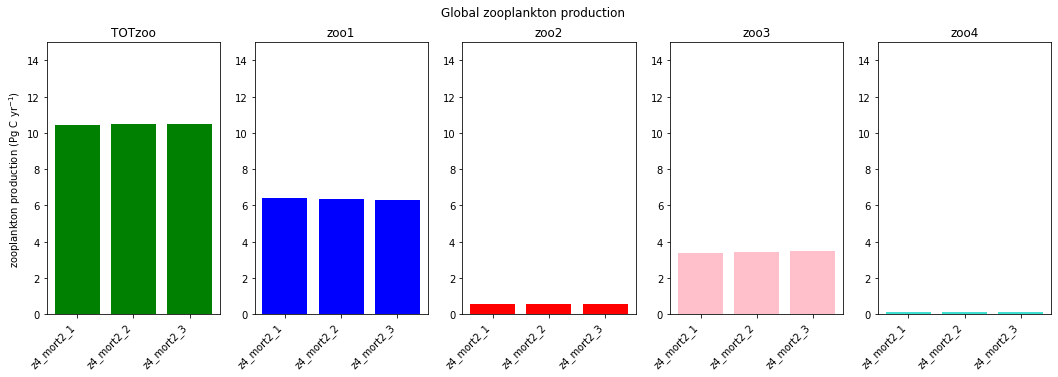

In [17]:
fig = plt.figure(figsize=(18,5))

plt.suptitle('Global zooplankton production')

####### TOT
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+[casenum]
    vals[i]=dict_glb[casenum].TOTzoo.values
    i=i+1
    
ax = fig.add_subplot(1,5,1)
ax.bar(labels, vals,color='green')
ax.set_ylim(0,15)
ax.set_ylabel('zooplankton production (Pg C yr$^{-1}$)')
ax.set_title('TOTzoo')
plt.xticks(rotation=45, ha='right')
####### sp
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+[casenum]
    vals[i]=dict_glb[casenum].x_graze_zoo1_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,2)
ax.bar(labels, vals,color='blue')
ax.set_ylim(0,15)
ax.set_title('zoo1')
plt.xticks(rotation=45, ha='right')

####### diat
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+[casenum]
    vals[i]=dict_glb[casenum].x_graze_zoo2_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,3)
ax.bar(labels, vals,color='red')
ax.set_ylim(0,15)
ax.set_title('zoo2')
plt.xticks(rotation=45, ha='right')

####### cocco
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+[casenum]
    vals[i]=dict_glb[casenum].x_graze_zoo3_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,4)
ax.bar(labels, vals,color='pink')
ax.set_ylim(0,15)
ax.set_title('zoo3')
plt.xticks(rotation=45, ha='right')

####### diaz
i=0
labels=[]
vals=np.zeros([3])
for casenum in casenums:
    
    labels=labels+[casenum]
    vals[i]=dict_glb[casenum].x_graze_zoo4_zint.values
    i=i+1
    
ax = fig.add_subplot(1,5,5)
ax.bar(labels, vals,color='turquoise')
ax.set_ylim(0,15)
ax.set_title('zoo4')
plt.xticks(rotation=45, ha='right');

#### Zooplankton production should be ~25% of NPP
#### Microzooplankton (zoo1 + zoo2) should be ~60% of total zooplankton production

#### Zooplankton production = (zoo grazing - zoo respiration)

### COPEPOD comparison

In [18]:
#the m00 is the annual data, and m01-m12 are monthlies, and then m13-16 are quarterlies.
#file='/glade/work/jluo/obs/COPEPOD/data/copepod-2012__cmass-m00-qtr_POP_gx3v7.nc'
file = '/glade/u/home/kristenk/regridding/data/POP_gx3v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file)
ds_copepod['copepod_C']=ds_copepod.copepod_C/12.011

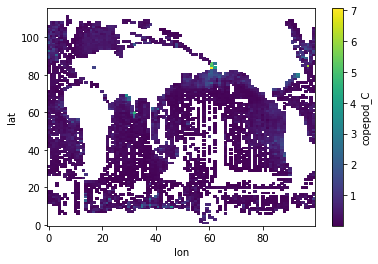

In [19]:
ds_copepod.copepod_C.plot()

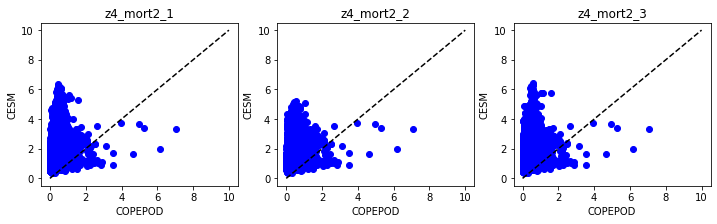

In [20]:
#### make line plots plotting mesozooplankton abundance versus COPEPOD database

### PREP
one2one = np.array([0, 10])
x_vals = ds_copepod.copepod_C.values
x_vals = x_vals.flatten()

fig = plt.figure(figsize=(12,3))
plotnum=0
for casenum in casenums:
        plotnum=plotnum+1
        
        #set up the vals
        y_vals = ds_dict[casenum].zoo3C.isel(z_t_150m=0).values
        y_vals = y_vals.flatten()
        
        
        ax = fig.add_subplot(1,3,plotnum)
        ax.set_title(casenum)
        ax.scatter(x_vals,y_vals,color='blue',marker='o',
                   label='control')
        ax.set_ylabel('CESM')
        ax.set_xlabel('COPEPOD')
        ax.plot(one2one,one2one,color='black',linestyle='--')

#ax.plot(yr_2iaf,line_alk_control,'--',color='blue')

## z_grz of zoo3 grazing on zoo2 tests

In [21]:
#define test cases
varname='z2z3_z_grz'
casenums=[varname+'_1', varname+'_2', varname+'_3']
test_vals=[0.1, 1, 2]

In [23]:
ds_dict = {}
for casenum in casenums:
    case=casename + 'test' + '.' + casenum
    print(case)
    files = []
    for year in range(start_yr,endyr):
        
        yr4 = "{:04d}".format(year)
        print('doing simulation year', year, '!')
        for month in range(1, 13):

            mo2 = "{:02d}".format(month)
            files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc')))
            
            ds = xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')
            ds = ds.drop([v for v in ds.variables if v not in keep_vars])
            ds = ds.mean(dim='time')
            
            ds_dict[casenum] = ds

g.e22a06.G1850ECOIAF.T62_g37.4p4z.test.z2z3_z_grz_1
doing simulation year 3 !
g.e22a06.G1850ECOIAF.T62_g37.4p4z.test.z2z3_z_grz_2
doing simulation year 3 !
g.e22a06.G1850ECOIAF.T62_g37.4p4z.test.z2z3_z_grz_3
doing simulation year 3 !


In [24]:
rmse_dict={}

for casenum in casenums:
    
    ds_dict[casenum]['z_t']=ds_woa.z_t

    rmse_global = xr.Dataset({v: ds_dict[casenum][v] for v in ['z_t']})
    #help(esmlab.statistics)
    rmse_global['NO3']=esmlab.statistics.weighted_rmsd(ds_dict[casenum].NO3, ds_woa.NO3, dim=['nlat', 'nlon'], weights=area)
    rmse_global['PO4']=esmlab.statistics.weighted_rmsd(ds_dict[casenum].PO4, ds_woa.PO4, dim=['nlat', 'nlon'], weights=area)
    rmse_global['SiO3']=esmlab.statistics.weighted_rmsd(ds_dict[casenum].SiO3, ds_woa.SiO3, dim=['nlat', 'nlon'], weights=area)
    
    rmse_dict[casenum]=rmse_global

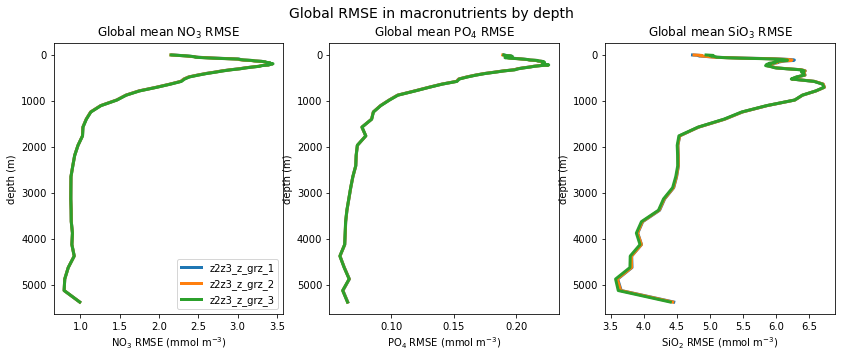

In [25]:
fig = plt.figure(figsize=(14,5))

plt.suptitle('Global RMSE in macronutrients by depth', fontsize=14)
#################
ax = fig.add_subplot(1,3,1)
ax.set_title('Global mean NO$_3$ RMSE')
for casenum in casenums:
    ax.plot(rmse_dict[casenum]['NO3'].values, depths, label=casenum, linewidth=3)
ax.legend()
ax.set(ylabel='depth (m)',xlabel='NO$_3$ RMSE (mmol m$^{-3}$)')
plt.gca().invert_yaxis()
#################
ax = fig.add_subplot(1,3,2)
ax.set_title('Global mean PO$_4$ RMSE')
for casenum in casenums:
    ax.plot(rmse_dict[casenum]['PO4'].values, depths, label=casenum, linewidth=3)
ax.set(ylabel='depth (m)',xlabel='PO$_4$ RMSE (mmol m$^{-3}$)')
plt.gca().invert_yaxis()
#################
ax = fig.add_subplot(1,3,3)
ax.set_title('Global mean SiO$_3$ RMSE')
for casenum in casenums:
    ax.plot(rmse_dict[casenum]['SiO3'].values, depths, label=casenum, linewidth=3)
ax.set(ylabel='depth (m)',xlabel='SiO$_2$ RMSE (mmol m$^{-3}$)')
plt.gca().invert_yaxis()
#################

In [26]:
nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

variables = [f'photoC_{phyto}_zint' for phyto in ['diat', 'sp', 'diaz', 'cocco', 'TOT']]

variables = variables + [f'x_graze_{zoo}_zint' for zoo in ['zoo1', 'zoo2', 'zoo3','zoo4']]

dict_glb = {}
for casenum in casenums:
    
    ds_glb = xr.Dataset()
    for v in variables:
        ds_glb[v] = esmlab.statistics.weighted_sum(ds_dict[casenum][v], weights=area, dim=['nlat', 'nlon'])
        ds_glb[v].attrs = ds_dict[casenum][v].attrs

        #if ds1_annmean[v].units == 'mmol/m^3 cm/s':
        ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
        ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'

    ds_glb = ds_glb.compute()
    
    ds_glb['TOTzoo']= ds_glb['x_graze_zoo1_zint'] + ds_glb['x_graze_zoo2_zint'] + ds_glb['x_graze_zoo3_zint'] + ds_glb['x_graze_zoo4_zint']
    
    dict_glb[casenum]=ds_glb

Text(0.5, 0, 'z2z3_z_grz')

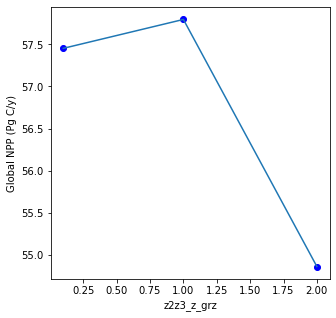

In [29]:
y_vals = np.empty([3])
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].photoC_TOT_zint.values
    i=i+1
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.scatter(test_vals,y_vals,color='blue',marker='o')
ax.plot(test_vals,y_vals)
ax.set_ylabel('Global NPP (Pg C/y)')
ax.set_xlabel(varname)
#ax.set_ylim(50,60)

Text(0.5, 0, 'z2z3_z_grz')

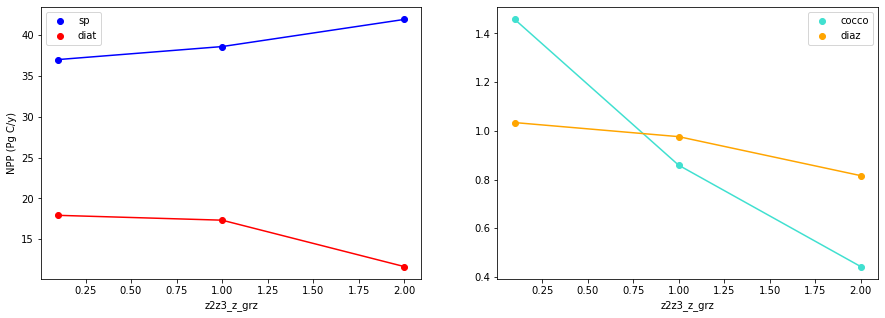

In [31]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1,2,1)
y_vals = np.empty([3])
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].photoC_sp_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='blue',marker='o',label='sp')
ax.plot(test_vals,y_vals,color='blue')
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].photoC_diat_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='red',marker='o',label='diat')
ax.plot(test_vals,y_vals,color='red')
ax.legend()
ax.set_ylabel('NPP (Pg C/y)')
ax.set_xlabel(varname)

ax = fig.add_subplot(1,2,2)
y_vals = np.empty([3])
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].photoC_cocco_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='turquoise',marker='o',label='cocco')
ax.plot(test_vals,y_vals,color='turquoise')
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].photoC_diaz_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='orange',marker='o',label='diaz')
ax.plot(test_vals,y_vals,color='orange')
ax.legend()
ax.set_xlabel(varname)

Text(0.5, 0, 'z2z3_z_grz')

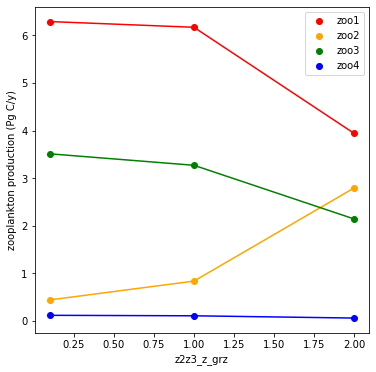

In [36]:
fig = plt.figure(figsize=(6,6))

ax = fig.add_subplot(1,1,1)
y_vals = np.empty([3])
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].x_graze_zoo1_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='red',marker='o',label='zoo1')
ax.plot(test_vals,y_vals,color='red')
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].x_graze_zoo2_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='orange',marker='o',label='zoo2')
ax.plot(test_vals,y_vals,color='orange')
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].x_graze_zoo3_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='green',marker='o',label='zoo3')
ax.plot(test_vals,y_vals,color='green')
i=0
for casenum in casenums:
    y_vals[i]=dict_glb[casenum].x_graze_zoo4_zint.values
    i=i+1
ax.scatter(test_vals,y_vals,color='blue',marker='o',label='zoo4')
ax.plot(test_vals,y_vals,color='blue')

ax.legend()
ax.set_ylabel('zooplankton production (Pg C/y)')
ax.set_xlabel(varname)


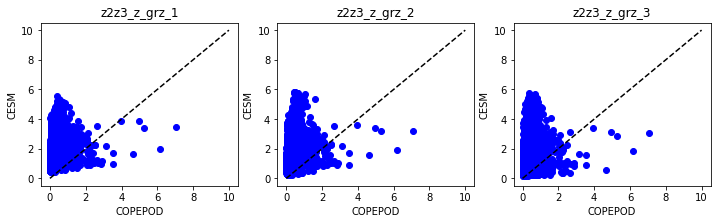

In [35]:
#### make line plots plotting mesozooplankton abundance versus COPEPOD database

### PREP
one2one = np.array([0, 10])
x_vals = ds_copepod.copepod_C.values
x_vals = x_vals.flatten()

fig = plt.figure(figsize=(12,3))
plotnum=0
for casenum in casenums:
        plotnum=plotnum+1
        
        #set up the vals
        y_vals = ds_dict[casenum].zoo3C.isel(z_t_150m=0).values
        y_vals = y_vals.flatten()
        
        
        ax = fig.add_subplot(1,3,plotnum)
        ax.set_title(casenum)
        ax.scatter(x_vals,y_vals,color='blue',marker='o',
                   label='control')
        ax.set_ylabel('CESM')
        ax.set_xlabel('COPEPOD')
        ax.plot(one2one,one2one,color='black',linestyle='--')

#ax.plot(yr_2iaf,line_alk_control,'--',color='blue')